# Delta-X 2022 Applications Workshop

# Estimating Water Surface Elevation and Slope from AirSWOT

© 2022 California Institute of Technology. Government sponsorship acknowledged.

Author: Michael Denbina, Jet Propulsion Laboratory, California Institute of Technology

---

The AirSWOT tutorial is split into three modules, which cover:

1. AirSWOT Data Introduction
2. Estimating Water Surface Elevation and Slope from AirSWOT (this module)
3. Comparing AirSWOT to In Situ Data

In this module, we will show how to use a water mask to mask out AirSWOT pixels that are not open water, how to filter outliers, and how to spatially average AirSWOT height data in order to produce accurate estimates of water surface elevation for a waterbody of interest.

Let us say, for example, that we would like to monitor the water surface elevation of the lake at the center of the Google Earth imagery below:

![Terrebonne Lake](images/qgis_terrebonne_lake.png)

This lake is located in the Eastern Terrebonne Basin, and was imaged by AirSWOT during the Delta-X Spring campaign during three flights on April 12, April 16, and April 18, 2021.  The green marker shows the location of a nearby water level station managed by the Coastwide Reference Monitoring System (CRMS).  We will compare AirSWOT to data from that station in the next module.

By inspecting the AirSWOT L2 data products in QGIS, we can identify a large number of flight lines that have coverage over this area.  For the purposes of this example, we will use the following four flight lines (two each from two different flights):

- 20210416005432
- 20210416041720
- 20210418164312
- 20210418202023

We will begin by importing a number of modules that we need, and then pointing to the location where the data has been downloaded, similar to the first module.

**Note**: As in the previous module, you may need to update the variable "data_path" and data filenames to point to where the data is located if you have moved the data or downloaded it separately rather than using the sample data included with this tutorial.

In [ ]:
# Setup Google Colab:
# If you aren't using Google Colab -- skip running this cell.

# For access to Google Drive files
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# For saving to Google Drive
from google.colab import drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Gdrive = GoogleDrive(gauth)

drive.mount('/content/drive',force_remount=True)

In [ ]:
# Data path pointing to AirSWOT sample data and associated files:
data_path = '/content/drive/MyDrive/DeltaX_Workshop_2022/Tutorials/2_AirSWOT'

# By default, this is pointing to the location of the data on your Google Drive
# (assuming you added a shortcut to the workshop materials).

# If you are running on your local machine, update data_path to the location where you
# saved the files.

In [228]:
# Import useful libraries
import os
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

# Filenames of the GeoTIFFs we wish to analyze, relative to data_path.
hgt_raster_files = np.array(['L2/utm_m0m_20210416005432.hgt.tif',
                             'L2/utm_m0m_20210416041720.hgt.tif',
                             'L2/utm_m0m_20210418164312.hgt.tif',
                             'L2/utm_m0m_20210418202023.hgt.tif'])

Recall that the AirSWOT products are in UTM Zone 15 North coordinates, not in latitude/longitude.  Therefore, we need to know the UTM coordinates of the lake we wish to analyze.  After inspecting the area in QGIS, we see that the lake center is approximately located at X = 719400 m, Y = 3246000 m.  The coordinates of the cursor position can be viewed in QGIS at the bottom of the screen.

Now, we will demonstrate how to convert a position in UTM coordinates to the raster coordinates (image line and image row) of the AirSWOT L2 product.

In [229]:
# Load the first dataset using GDAL.
hgt_product = gdal.Open(os.path.join(data_path, hgt_raster_files[0]))
hgt_product_geo = hgt_product.GetGeoTransform()

# GDAL defines the grid origin and spacing using the "GeoTransform":
print('GDAL GeoTransform of AirSWOT L2 Product:')
print(hgt_product_geo)
print('')

# The X coordinate origin is stored in element [0] of the geo transform:
print('X Origin for this Raster: {}'.format(hgt_product_geo[0]))

# The Y coordinate origin is stored in element [3] of the geo transform:
print('Y Origin for this Raster: {}'.format(hgt_product_geo[3]))

# The X coordinate pixel spacing is stored in element [1] of the geo transform:
print('X Pixel Spacing for this Raster: {}'.format(hgt_product_geo[1]))

# The Y coordinate pixel spacing is stored in element [5] of the geo transform:
print('Y Pixel Spacing for this Raster: {}'.format(hgt_product_geo[5]))

# Let us now define a small function which will calculate the image row and image line:
def calculate_image_coords(x_coord, y_coord, geo_transform):
    x_origin = geo_transform[0]
    y_origin = geo_transform[3]
    x_spacing = geo_transform[1]
    y_spacing = geo_transform[5]
    
    row = (y_coord - y_origin) / y_spacing
    column = (x_coord - x_origin) / x_spacing
    
    return row, column

# Now, let's calculate the location of the lake in the AirSWOT data using its map coordinates:
x_lake = 719400
y_lake = 3246000
row_lake, column_lake = calculate_image_coords(x_lake, y_lake, hgt_product_geo)

print('')
print('Image Position of Lake:')
print('Row: {:.2f}'.format(row_lake))
print('Column: {:.2f}'.format(column_lake))

GDAL GeoTransform of AirSWOT L2 Product:
(709455.6, 3.6, 0.0, 3254785.2, 0.0, -3.6)

X Origin for this Raster: 709455.6
Y Origin for this Raster: 3254785.2
X Pixel Spacing for this Raster: 3.6
Y Pixel Spacing for this Raster: -3.6

Image Position of Lake:
Row: 2440.33
Column: 2762.33


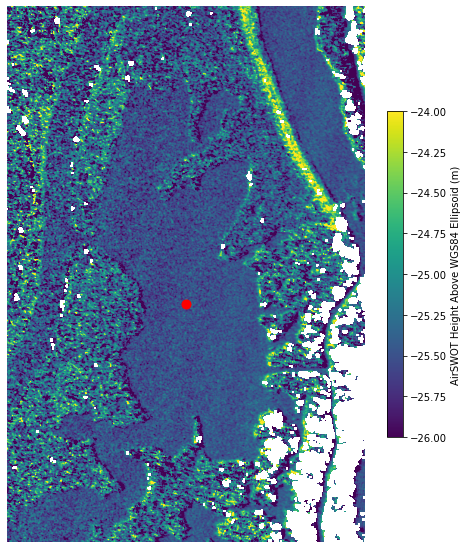

In [230]:
# Now that we know where the lake is in the image, let's plot it to make sure we calculated the right location:

# Read the data from the GeoTIFF into a NumPy array.
hgt_product_data = hgt_product.ReadAsArray()
hgt_product_data[hgt_product_data == -10000] = np.nan # Values of -10000 represent void data.

# Let's subset the AirSWOT data to an image chip containing the lake and surrounding area:
row_lake_int = int(row_lake)
column_lake_int = int(column_lake)
hgt_lake_chip = hgt_product_data[row_lake_int-500:row_lake_int+401,
                                column_lake_int-300:column_lake_int+301]

# Let's display the data using matplotlib.
plt.figure(figsize=(8,12))
plt.imshow(hgt_lake_chip, vmin=-26, vmax=-24)
plt.plot(300, 500, 'r.', markersize=18)
plt.axis('off')
cb = plt.colorbar(label='AirSWOT Height Above WGS84 Ellipsoid (m)', shrink=0.5)

We found it!  We can see the lake near the center of the image.  The lake surface has relatively smooth height values across its surface, while the surrounding wetland and man-made structures show a greater variation in  height.  Note that as we might expect, the elevation of the wetland vegetation and man-made structures are above the surface of the water.  If we included any of these non-water pixels in our estimate of the water surface elevation, our results would be positively biased compared to the true water surface level.

Therefore, we must filter out non-water areas.  One way to do this is by using a water mask.  There many possible sources of such data, such as using other remote sensing data to derive a landcover classification, or drawing a manual mask.  For this exercise, you may find a water mask derived from Sentinel-2 data in the sample data included with this notebook.  The Sentinel-2 water mask is from the following paper:

Thomas, N.; Simard, M.; Castañeda-Moya, E.; Byrd, K.; Windham-Myers, L.; Bevington, A.; Twilley, R.R.
High-resolution mapping of biomass and distribution of marsh and forested wetlands in southeastern
coastal Louisiana. Int. J. Appl. Earth Obs. Geoinf. 2019, 80, 257 – 267. [Link to Paper](http://dx.doi.org/10.1016/j.jag.2019.03.013)

As an exercise, you could also use your own water mask, or create your own mask by manually selecting water pixels within the lake.

To apply an external mask to the AirSWOT data, we must interpolate the value of the mask for each AirSWOT image pixel.  We will do that now.  Below, we have provided some functions to help with this.

**Note**: For these functions to work, all of your data must be in the same coordinate reference system.  In this case, the provided water mask is also in UTM Zone 15 North like the AirSWOT data (EPSG:32615), so you do not need to worry about changing the coordinate system of the data.  If you do need to reproject raster data to a different coordinate system, you can do so using QGIS, [GDAL](https://gdal.org/programs/gdalwarp.html), [RasterIO](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html), or other methods.

In [231]:
def nearest_interpolate(data, x, y, nodataval=np.nan):
    """Function to perform nearest neighbor interpolation on the input array
        data, at the image coordinates given by input arguments x and y.

    Arguments
        data (array): 2D array containing raster data to interpolate.
        x (array): the X coordinate values at which to interpolate (in array
            indices, starting at zero).  Note that X refers to the second
            dimension of data (e.g., the columns).
        y (array): the Y coordinate values at which to interpolate (in array
            indices, starting at zero).  Note that Y refers to the first
            dimension of data (e.g., the rows).
        nodataval: No data value for points outside of the data bounds.

    Returns:
        intdata (array): The 2D interpolated array, with same dimensions as
            x and y.

    """
    x = np.asarray(x)
    y = np.asarray(y)

    x = np.round(x).astype('int32')
    y = np.round(y).astype('int32')

    ind = (x < 0) | (y < 0) | (x >= data.shape[1]) | (y >= data.shape[0])

    if np.any(ind):
        x[ind] = 0
        y[ind] = 0

    intdata = (data[y, x]).astype('float32')

    if np.any(ind):
        intdata[ind] = nodataval

    return intdata


def interp_raster_at_xy(data, geo_transform, x, y):
    """ Interpolate values of raster at input coordinates using nearest
        neighbor interpolation. """
    # Calculate the image coordinates from the given map coordinates:
    rows, columns = calculate_image_coords(x, y, geo_transform)
    
    # Calculate the mask value at the given coordinates using nearest neighbor interpolation:
    ds_interp = nearest_interpolate(data, columns, rows)
    return ds_interp


def get_coords_of_image_chip(geo_transform, rows, cols):
    """ Calculate the map coordinates for a given image chip using
        the geo_transform and image coordinates of that chip. """
    x_coords = cols*geo_transform[1] + geo_transform[0]
    y_coords = rows*geo_transform[5] + geo_transform[3]
    return x_coords, y_coords

Using the above functions, we will now load the water mask using GDAL and resample it at the coordinates of the AirSWOT image chip that we selected.

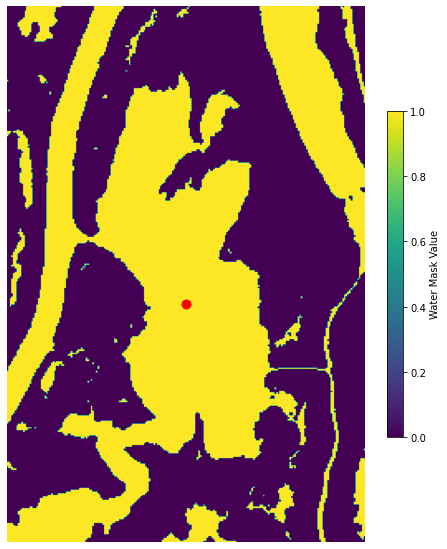

In [232]:
# Load the water mask.
water_mask_file = os.path.join(data_path, 'water_mask/Sentinel2_DOS_mosaic_sub_EVI_mask.tif')
water_mask = gdal.Open(water_mask_file)
water_mask_data = water_mask.ReadAsArray()
water_mask_geo = water_mask.GetGeoTransform()

# Calculate the row and column image coordinates for each pixel in the AirSWOT image chip.
rows_lake_chip = np.arange(row_lake_int-500, row_lake_int+401)
columns_lake_chip = np.arange(column_lake_int-300, column_lake_int+301)
rows_lake_chip = np.tile(rows_lake_chip, (len(columns_lake_chip), 1)).T
columns_lake_chip = np.tile(columns_lake_chip, (len(rows_lake_chip), 1))

# Calculate the X and Y UTM coordinates for each pixel in the AirSWOT image chip.
x_lake_chip, y_lake_chip = get_coords_of_image_chip(hgt_product_geo, rows_lake_chip, columns_lake_chip)

# Interpolate the value of the water mask at the desired coordinates:
water_mask_lake_chip = interp_raster_at_xy(water_mask_data, water_mask_geo, x_lake_chip, y_lake_chip)
water_mask_lake_chip = water_mask_lake_chip > 0

# Plot the interpolated water mask:
plt.figure(figsize=(8,12))
plt.imshow(water_mask_lake_chip)
plt.plot(300, 500, 'r.', markersize=18)
plt.axis('off')
cb = plt.colorbar(label='Water Mask Value', shrink=0.5)

The mask looks reasonable, however, we waant to estimate the water surface elevation of the lake, not necessarily the surrounding channels.  If we erode the water mask, we can isolate the lake pixels, as well as filter out pixels close to land where there is more likely to be errors in the water mask due to misregistration or the different spatial resolution of the water mask and AirSWOT.

Label Corresponding to Lake: 3


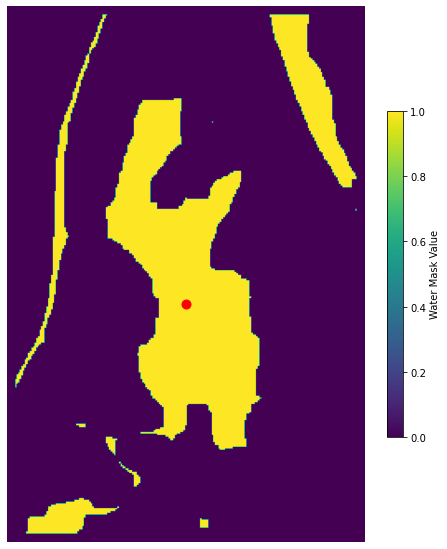

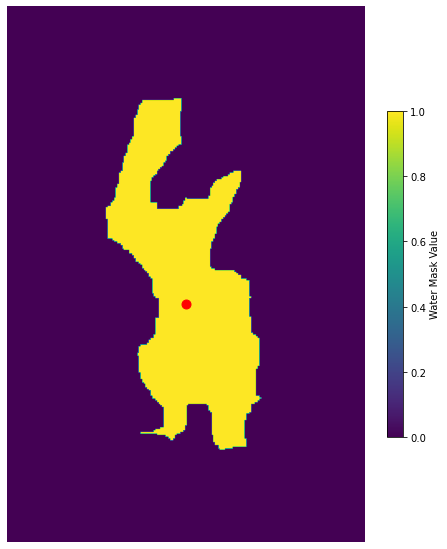

In [233]:
from scipy.ndimage import binary_erosion, label

# Erode the water mask to isolate the lake:
water_mask_lake_eroded = binary_erosion(water_mask_lake_chip, structure=np.ones((3,3)), iterations=14)

# Plot the eroded water mask:
plt.figure(figsize=(8,12))
plt.imshow(water_mask_lake_eroded)
plt.plot(300, 500, 'r.', markersize=18)
plt.axis('off')
cb = plt.colorbar(label='Water Mask Value', shrink=0.5)

# We want to select only the masked pixels that are still part of the lake in the eroded image.
# To do that, we will label each contiguous set of water pixels using scipy.ndimage.label.
water_mask_labelled, _ = label(water_mask_lake_eroded, structure=np.ones((3,3)))
lake_label = water_mask_labelled[500, 300] # select the label corresponding to the lake
print('Label Corresponding to Lake: {}'.format(lake_label))

# The water mask should only be true for the lake itself:
water_mask_labelled = (water_mask_labelled == lake_label)

# Plot the labelled water mask data:
plt.figure(figsize=(8,12))
plt.imshow(water_mask_labelled)
plt.plot(300, 500, 'r.', markersize=18)
plt.axis('off')
cb = plt.colorbar(label='Water Mask Value', shrink=0.5)

Now we have a mask that only includes the lake.  Let's mask the AirSWOT data again and perform a simple outlier filtering step using a [median absolute deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) filter.  We perform this outlier filtering step just in case there are any incorrectly masked pixels, or objects in the water such as boats or buoys, or other potential error sources.

Mean AirSWOT Height Before Masking: -25.41 m
Mean AirSWOT Height After Masking: -25.51 m
Mean AirSWOT Height After Masking and Outlier Filtering: -25.50 m



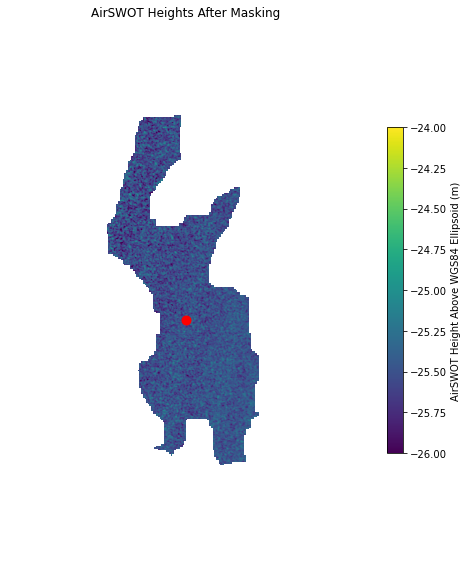

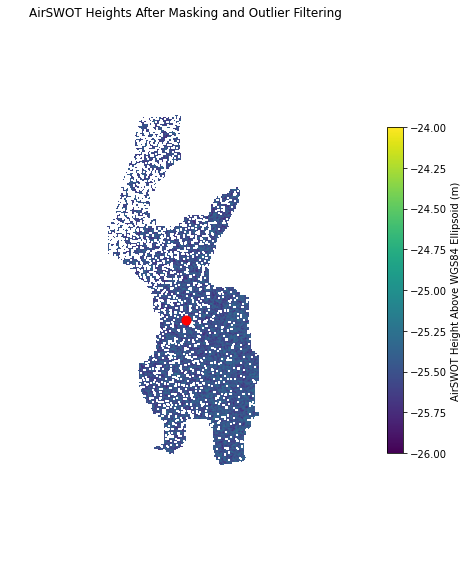

In [234]:
hgt_lake_chip_masked = hgt_lake_chip.copy()

# Set all AirSWOT data to void when the water mask is land (not equal to 1).
hgt_lake_chip_masked[water_mask_labelled < 1] = np.nan

# Plot the masked AirSWOT height data before outlier filtering:
plt.figure(figsize=(8,12))
plt.imshow(hgt_lake_chip_masked, vmin=-26, vmax=-24)
plt.plot(300, 500, 'r.', markersize=18)
plt.axis('off')
plt.title('AirSWOT Heights After Masking')
cb = plt.colorbar(label='AirSWOT Height Above WGS84 Ellipsoid (m)', shrink=0.5)

# Filter outliers using a median absolute deviation filter.
def filter_points_mad(z, thresh=2):
    # Remove height outliers.
    if np.any(np.isfinite(z)):
        med = np.nanmedian(z)
        abs_dev = np.abs(z - med)
        left_mad = np.nanmedian(abs_dev[z <= med])
        right_mad = np.nanmedian(abs_dev[z >= med])

        z_mad = left_mad * np.ones(z.shape)
        z_mad[z > med] = right_mad

        h_score = 0.6745 * abs_dev / z_mad
        h_score[z == med] = 0

        ind = (h_score <= thresh) & np.isfinite(z)
    else:
        ind = np.isfinite(z)

    return ind


print('Mean AirSWOT Height Before Masking: {:.2f} m'.format(np.nanmean(hgt_lake_chip)))
print('Mean AirSWOT Height After Masking: {:.2f} m'.format(np.nanmean(hgt_lake_chip_masked)))

indices_to_keep = filter_points_mad(hgt_lake_chip_masked)
hgt_lake_chip_masked_filtered = hgt_lake_chip_masked.copy()
hgt_lake_chip_masked_filtered[~indices_to_keep] = np.nan

print('Mean AirSWOT Height After Masking and Outlier Filtering: {:.2f} m'.format(np.nanmean(hgt_lake_chip_masked_filtered)))
print('')

# Plot the masked AirSWOT height data after outlier filtering:
plt.figure(figsize=(8,12))
plt.imshow(hgt_lake_chip_masked_filtered, vmin=-26, vmax=-24)
plt.plot(300, 500, 'r.', markersize=18)
plt.axis('off')
plt.title('AirSWOT Heights After Masking and Outlier Filtering')
cb = plt.colorbar(label='AirSWOT Height Above WGS84 Ellipsoid (m)', shrink=0.5)

In addition to calculating the water surface elevation, one of the advantages of AirSWOT compared to point water level data is that AirSWOT produces an image of the water surface rather than a water surface at specific points.  Therefore, we can calculate not just the elevation of the water in the lake, but also the slope of the water surface within the lake.

To do this, we will fit a plane to the AirSWOT water surface in 3-D coordinates, as shown in the example below.

Coefficients from Plane Fit:
[ 5.7863951e+00 -2.0540180e+00 -2.5504595e+03]

X Slope of Plane: 5.786395072937012
Y Slope of Plane: -2.054018020629883
Height of Plane (at Center of Lake): -25.5045947265625


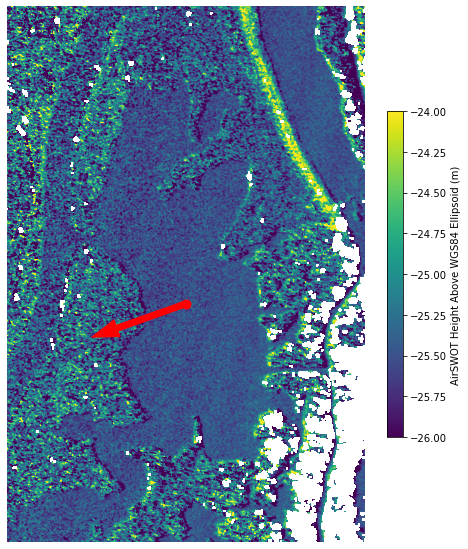

In [235]:
from numpy.linalg import lstsq # Function to solve an equation using least squares.

# Fit a plane in 3-D to the lake surface.
def calc_slope_from_plane_fit(x, y, z):
    ind_valid_data = np.isfinite(z)
    
    # Include only data with finite height values in the fit.
    # Convert X and Y coordinates to km, and Z coordinate to cm, so that resulting
    # slope will be in cm/km.
    x_fit = x[ind_valid_data] / 1e3
    y_fit = y[ind_valid_data] / 1e3
    z_fit = z[ind_valid_data] * 100
    
    xy_fit = np.zeros((len(z_fit), 3), dtype='float32')
    # We subtract the mean X and Y so that the third coefficient is equal to the
    # water surface elevation near the center of the lake, rather than at the
    # UTM origin.
    xy_fit[:, 0] = x_fit - np.nanmean(x_fit)
    xy_fit[:, 1] = y_fit - np.nanmean(y_fit)
    xy_fit[:, 2] = 1
    
    coefs, residuals, rank, singular = lstsq(xy_fit, z_fit, rcond=None)
    return coefs, residuals, rank, singular

coefs, residuals, rank, singular = calc_slope_from_plane_fit(x_lake_chip, y_lake_chip, hgt_lake_chip_masked_filtered)

print('Coefficients from Plane Fit:')
print(coefs)
print('')
print('X Slope of Plane: {}'.format(coefs[0]))
print('Y Slope of Plane: {}'.format(coefs[1]))
print('Height of Plane (at Center of Lake): {}'.format(coefs[2]/100))

# Plot an arrow representing the slope on the image of the lake.
plt.figure(figsize=(8,12))
plt.imshow(hgt_lake_chip, vmin=-26, vmax=-24)
plt.plot(300, 500, 'r.', markersize=18)
plt.arrow(300, 500, -1*coefs[0]*20, -1*coefs[1]*20, color='r', width=10)
plt.axis('off')
cb = plt.colorbar(label='AirSWOT Height Above WGS84 Ellipsoid (m)', shrink=0.5)

In the image above, we multiply the slope by -1 when plotting the arrow so that the arrow points down the slope, in the direction that we estimate the water is flowing, on average.  This kind of spatial information is one of the key advantages of AirSWOT compared to in situ water level data, in that AirSWOT collects a continuous image of the water surface rather than an estimate at discrete points.

Note that for this case, the outlier filtering didn't change the mean elevation within the lake.  The distribution of the pixels masked by the outlier filter in this case appears random.  In the next module, however, we will show an example where the outlier filtering step is valuable.

Let's now go through all of the above steps for each of the AirSWOT flight lines that we selected at the beginning of this module.  This will allow us to monitor how the water surface elevation and slope of the lake changes over time.

This time, we will also parse the datetime ID of each L2 product from its filename, and track the UTC datetime corresponding to each water surface elevation.  We will then plot the water surface elevation vs. the time of acquisition.

At 2021-04-16 00:54:32, the WSE in the lake was -25.50 m with respect to the WGS84 ellipsoid.
                        the WSS in the X direction was 5.79 cm/km.
                        the WSS in the Y direction was -2.05 cm/km.

At 2021-04-16 04:17:20, the WSE in the lake was -25.56 m with respect to the WGS84 ellipsoid.
                        the WSS in the X direction was 0.41 cm/km.
                        the WSS in the Y direction was -4.91 cm/km.

At 2021-04-18 16:43:12, the WSE in the lake was -25.45 m with respect to the WGS84 ellipsoid.
                        the WSS in the X direction was 0.77 cm/km.
                        the WSS in the Y direction was -1.31 cm/km.

At 2021-04-18 20:20:23, the WSE in the lake was -25.34 m with respect to the WGS84 ellipsoid.
                        the WSS in the X direction was 8.02 cm/km.
                        the WSS in the Y direction was -1.11 cm/km.



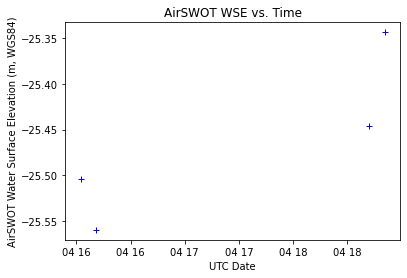

In [236]:
import datetime # Python module for dealing with datetimes.

# Empty arrays to store the WSE and datetimes.
airswot_wse = np.array([], dtype='float32')
airswot_datetime = np.array([], dtype=datetime.datetime)
airswot_wss_x = np.array([], dtype='float32')
airswot_wss_y = np.array([], dtype='float32')
airswot_hgt_stack = None

# Loop through the AirSWOT L2 rasters, calculating the water surface elevation of the lake for each raster.
for file in hgt_raster_files:
    hgt_product = gdal.Open(os.path.join(data_path, file))
    hgt_product_data = hgt_product.ReadAsArray()
    hgt_product_data[hgt_product_data == -10000] = np.nan # Values of -10000 represent void data.
    hgt_product_geo = hgt_product.GetGeoTransform()
    
    # Calculate the AirSWOT image coordinates corresponding to the lake:
    row_lake, column_lake = calculate_image_coords(x_lake, y_lake, hgt_product_geo)
    
    # Subset the AirSWOT data to an image chip containing the lake and surrounding area:
    row_lake_int = int(row_lake)
    column_lake_int = int(column_lake)
    hgt_lake_chip = hgt_product_data[row_lake_int-500:row_lake_int+401,
                                    column_lake_int-300:column_lake_int+301]

    # Calculate the row and column image coordinates for each pixel in the AirSWOT image chip.
    rows_lake_chip = np.arange(row_lake_int-500, row_lake_int+401)
    columns_lake_chip = np.arange(column_lake_int-300, column_lake_int+301)
    rows_lake_chip = np.tile(rows_lake_chip, (len(columns_lake_chip), 1)).T
    columns_lake_chip = np.tile(columns_lake_chip, (len(rows_lake_chip), 1))
    
    # Calculate the X and Y UTM coordinates for each pixel in the AirSWOT image chip.
    x_lake_chip, y_lake_chip = get_coords_of_image_chip(hgt_product_geo, rows_lake_chip, columns_lake_chip)

    # Interpolate the value of the water mask at the desired coordinates:
    water_mask_lake_chip = interp_raster_at_xy(water_mask_data, water_mask_geo, x_lake_chip, y_lake_chip)
    water_mask_lake_chip = water_mask_lake_chip > 0
    
    # Erode the water mask to isolate the lake:
    water_mask_lake_eroded = binary_erosion(water_mask_lake_chip, structure=np.ones((3,3)), iterations=14)

    # We want to select only the masked pixels that are still part of the lake in the eroded image.
    # To do that, we will label each contiguous set of water pixels using scipy.ndimage.label.
    water_mask_labelled, _ = label(water_mask_lake_eroded, structure=np.ones((3,3)))
    lake_label = water_mask_labelled[500, 300] # select the label corresponding to the lake

    # The water mask should only include the lake itself:
    water_mask_labelled = (water_mask_labelled == lake_label)
    
    # Mask the AirSWOT height data:
    hgt_lake_chip_masked = hgt_lake_chip.copy()
    hgt_lake_chip_masked[water_mask_labelled < 1] = np.nan

    # Apply the outlier filter:
    indices_to_keep = filter_points_mad(hgt_lake_chip_masked)
    hgt_lake_chip_masked_filtered = hgt_lake_chip_masked.copy()
    hgt_lake_chip_masked_filtered[~indices_to_keep] = np.nan
    
    # Calculate the water surface elevation as the mean height in the masked lake:
    temp_wse = np.nanmean(hgt_lake_chip_masked_filtered)
    
    # Calculate the water surface slope using a plane fit:
    coefs, residuals, rank, singular = calc_slope_from_plane_fit(x_lake_chip, y_lake_chip, hgt_lake_chip_masked_filtered)
    
    # Let's also parse the AirSWOT product filename to a datetime:
    datetime_string = file.split('_')[2].split('.')[0]
    year = int(datetime_string[0:4])
    month = int(datetime_string[4:6])
    day = int(datetime_string[6:8])
    hour = int(datetime_string[8:10])
    minute = int(datetime_string[10:12])
    second = int(datetime_string[12:14])
    
    temp_datetime = datetime.datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)
    
    # Append the values for this flight line to the arrays:
    airswot_wse = np.append(airswot_wse, temp_wse)
    airswot_datetime = np.append(airswot_datetime, temp_datetime)
    airswot_wss_x = np.append(airswot_wss_x, coefs[0])
    airswot_wss_y = np.append(airswot_wss_y, coefs[1])
    
    if airswot_hgt_stack is None:
        airswot_hgt_stack = hgt_lake_chip[np.newaxis, :, :]
    else:
        airswot_hgt_stack = np.append(airswot_hgt_stack, hgt_lake_chip[np.newaxis, :, :], axis=0)
        

# Print the results:
for num in range(len(airswot_wse)):
    print('At {}, the WSE in the lake was {:.2f} m with respect to the WGS84 ellipsoid.'.format(airswot_datetime[num], airswot_wse[num]))
    print('                        the WSS in the X direction was {:.2f} cm/km.'.format(airswot_wss_x[num]))
    print('                        the WSS in the Y direction was {:.2f} cm/km.'.format(airswot_wss_y[num]))
    print('')

# Plot the water surface elevation time series:
plt.figure()
plt.plot(airswot_datetime, airswot_wse, 'b+')
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m %d')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('AirSWOT WSE vs. Time')
xlbl = plt.xlabel('UTC Date')
ylbl = plt.ylabel('AirSWOT Water Surface Elevation (m, WGS84)')

[-25.504597 -25.560078 -25.446281 -25.34314 ]
[datetime.datetime(2021, 4, 16, 0, 54, 32)
 datetime.datetime(2021, 4, 16, 4, 17, 20)
 datetime.datetime(2021, 4, 18, 16, 43, 12)
 datetime.datetime(2021, 4, 18, 20, 20, 23)]


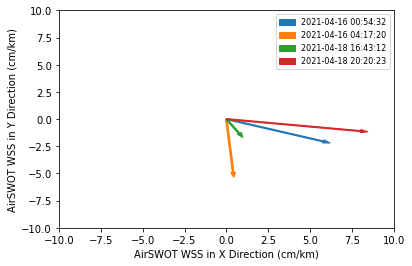

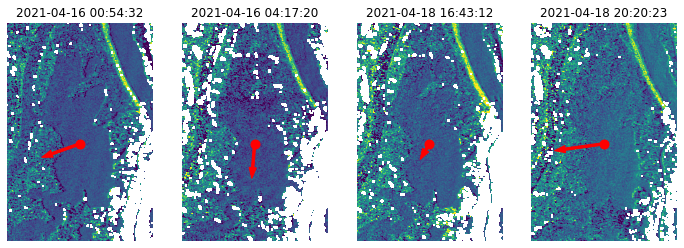

In [237]:
# Plot the AirSWOT water surface slope values directly, in units of cm/km:
plt.figure()
for num in range(len(airswot_wse)):
    plt.arrow(0, 0, airswot_wss_x[num], airswot_wss_y[num], width=0.1, color='C{}'.format(num), label=airswot_datetime[num])

plt.xlabel('AirSWOT WSS in X Direction (cm/km)')
plt.ylabel('AirSWOT WSS in Y Direction (cm/km)')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.legend(loc=0, frameon=True, fontsize=8)

# Plot the direction of water flow on the AirSWOT height data for each flightline.
plt.figure(figsize=(12,6))
for num in range(len(airswot_wss_x)):
    plt.subplot(1, 4, num+1)
    plt.imshow(airswot_hgt_stack[num], vmin=-26, vmax=-24)
    plt.plot(300, 500, 'r.', markersize=18)
    plt.arrow(300, 500, -1*airswot_wss_x[num]*20, -1*airswot_wss_y[num]*20, color='r', width=10)
    plt.title(airswot_datetime[num])
    plt.axis('off')

print(airswot_wse)
print(airswot_datetime)

OK, great!  But... how do we check the accuracy of the water surface elevation, and whether the direction of the water surface slope makes sense?

One way to check our results is by comparing AirSWOT to data from in situ water level stations.  As you'll notice from the above plots, while AirSWOT has fine spatial resolution, the temporal resolution is coarse as it is limited to repeat passes by the aircraft.  This is the opposite of in situ data, which has coarse spatial resolution (limited to the station locations, which tend to be sparsely distributed), but fine temporal resolution (with measurements taken every few minutes).  By comparing AirSWOT with in situ data, we can consider the AirSWOT measurements in the context of a more densely-sampled time series.


## Wrapping Up

In this module, we covered:

1. How to apply a water mask to AirSWOT data to exclude land pixels from our analysis.
2. How to filter outliers and spatially average AirSWOT data to estimate water surface elevation in a waterbody of interest.
3. How to monitor water level changes over time using repeat passes of AirSWOT over the same lake in the Eastern Terrebonne Basin.
4. How to estimate the water surface slope of the lake by fitting a plane to masked and filtered AirSWOT data in 3-D coordinates.

In the next and final module, we will learn how to compare water surface elevations measured by AirSWOT to in situ data, and show an example of how AirSWOT can be used to estimate the vertical datum for in situ data with an unknown datum.